In [1]:
import os
import jieba
import string

### 1. Load Text Data

In [2]:
with open('ham_5000.utf8', encoding='utf-8') as f:
    ham_docs = f.readlines()
with open('spam_5001.utf8', encoding='utf-8') as f:
    spam_docs = f.readlines()

### 2. Clean Text Data
- We can filter out punctuation from tokens.
- We can remove tokens that are just punctuation or contain numbers by using an isalpha() check on each token.
- We can remove stop words.

In [3]:
with open('stopwords.txt', encoding='utf-8') as f:
    stopwords = f.read().split('\n')
    
def cleanText(docs):
    cleanedText = []
    for doc in docs:
        words = jieba.cut(doc)
        # remove remaining tokens that are not alphabetic, and
        # filter out stop words
        cleanedWords = [word for word in words
                       if word.isalpha() and word not in stopwords]
        sentence = ' '.join(cleanedWords)
        cleanedText.append(sentence)
    return cleanedText

clean_ham = cleanText(ham_docs)
clean_spam = cleanText(spam_docs)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Russe\AppData\Local\Temp\jieba.cache
Loading model cost 0.766 seconds.
Prefix dict has been built successfully.


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

def transformTextToSparseMat(text):
    vectorizer = CountVectorizer(binary=False)
    vector = vectorizer.fit_transform(text)
    vol = vectorizer.vocabulary_
    data = pd.DataFrame(vector.toarray())
    df = pd.DataFrame(vol.items(), columns=['key', 'value'])
    colnames = df.sort_values("value")["key"].values
    data.columns = colnames
    return data

data = []
data.extend(clean_ham)
data.extend(clean_spam)

full_features = transformTextToSparseMat(data)

features = pd.DataFrame(full_features.apply(sum,axis=0))
# keep tokens with > 5 occurrence
useful_features =  features.loc[features[0] > 5]
useful_features = useful_features.index.to_list()

X = full_features[useful_features]
y = []
y.extend(np.ones(5000))
y.extend(np.zeros(5001))

In [5]:
y = pd.DataFrame(y).astype('int8')

### 3. Save Prepared Data

In [68]:
X.to_csv('prepared.csv')

In [ ]:
X = pd.read_csv('prepared.csv')

### 4. Split into Train and Test Sets

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(8000, 6647) (2001, 6647)
(8000, 1) (2001, 1)


### 5. Fit Neural Network

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

n_voc = X_train.shape[1]

# define the model
def define_model(n_voc):
    # define network
    model = Sequential()
    model.add(Dense(100, input_shape=(n_voc,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined network
    model.summary()
    return model

model = define_model(n_voc)
# fit network
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=30, verbose=0)

#model.fit(X_train, y_train, epochs=10, verbose=2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               664800    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 664,901
Trainable params: 664,901
Non-trainable params: 0
_________________________________________________________________


In [21]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

#loss, acc = model.evaluate(X_test, y_test, verbose=0)
#print('Test Accuracy: %f' % (acc*100))

Train: 0.999, Test: 0.989


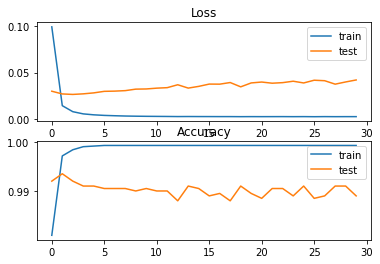

In [28]:
import matplotlib.pyplot as plt

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

y_pred = model.predict_classes(X_test)

print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('f1 score: ', f1_score(y_test, y_pred))
print('precision score: ', precision_score(y_test, y_pred))
print('recall score: ', recall_score(y_test, y_pred))

Confusion Matrix: 
 [[1006    4]
 [  17  974]]
f1 score:  0.98933468765871
precision score:  0.9959100204498977
recall score:  0.9828456104944501
